In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "O":
        le.fit(df[col])
        df[col] = le.transform(df[col])
        test[col] = le.transform(test[col])

In [4]:
x_cols = [col for col in df.columns if col not in ["id","Attrition"]]
y_cols = ["Attrition"]

In [5]:
att = df[df["Attrition"] == 1]
dff = pd.concat([df,att,att,att], axis = 0)

# Shuffle the DataFrame
shuffled_df = dff.sample(frac=1.0, random_state=42)

# Reset the index if needed
shuffled_df.reset_index(drop=True, inplace=True)


In [6]:
X = df[x_cols]
y = df[y_cols]

In [7]:
Xd = shuffled_df[x_cols]
xtest = test[x_cols]
yd = shuffled_df[y_cols]

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def cross_validation(X,y,estimator,n_splits):

    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    
    acc_scr = []
    f1_scr = []
    auc_scr = []
    

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  
        
        estimator.fit(X_train,y_train)
        
        y_preds = estimator.predict(X_test)
        
        acc_scr.append(accuracy_score(y_test,y_preds))
        f1_scr.append(f1_score(y_test,y_preds))
        auc_scr.append(roc_auc_score(y_test,estimator.predict_proba(X_test)[:, 1])) 
    
    avg_acc = round(np.mean(acc_scr),4)
    avg_f1 = round(np.mean(f1_scr),4)
    avg_roc = round(np.mean(auc_scr),4)
        
    print(f"Average accuracy score of {n_splits} is : {avg_acc}")
    print(f"Average f1 score of {n_splits} is       : {avg_f1}")
    print(f"Average roc score of {n_splits} is      : {avg_roc}")
    

In [11]:
param_grid = {'n_estimators':[380,400,450],
              'max_samples' :[320,350,400,450,500,600,800]
              }


dt = DecisionTreeClassifier(random_state=42)

bg = BaggingClassifier(estimator=dt,
                       bootstrap=True,
                       oob_score=True,
                       random_state=42)

grid_bg = GridSearchCV(estimator=bg,
                       param_grid=param_grid,
                       cv=5,
                       verbose=True,
                       scoring="f1")
grid_bg_d = GridSearchCV(estimator=bg,
                       param_grid=param_grid,
                       cv=5,
                       verbose=True,
                       scoring="f1")

In [12]:
grid_bg.fit(X,np.array(y).ravel())
grid_bg_d.fit(Xd,np.array(yd).ravel())

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                         oob_score=True, random_state=42),
             param_grid={'max_samples': [320, 350, 400, 450, 500, 600, 800],
                         'n_estimators': [380, 400, 450]},
             scoring='f1', verbose=True)

In [13]:
print(grid_bg.best_score_)
print(grid_bg_d.best_score_)

0.1986193853427896
0.9233755862163282


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
estimator = grid_bg.best_estimator_
estimator_d = grid_bg_d.best_estimator_
cross_validation(X,y,estimator,5)

Average accuracy score of 5 is : 0.8837
Average f1 score of 5 is       : 0.1599
Average roc score of 5 is      : 0.8039


In [16]:
cross_validation(Xd,yd,estimator_d,5)

Average accuracy score of 5 is : 0.9372
Average f1 score of 5 is       : 0.9161
Average roc score of 5 is      : 0.9888


In [21]:
samp_sub = pd.read_csv("dataset/sample_submission.csv")
samp_sub["Attrition"] = estimator_d.predict_proba(xtest)[:, 1]
samp_sub.to_csv("est_sub_bagging_d.csv", index=False)

There is Significant improvement with Bagging Classifier using Duplicate Attrition of values = 1

with probabilities

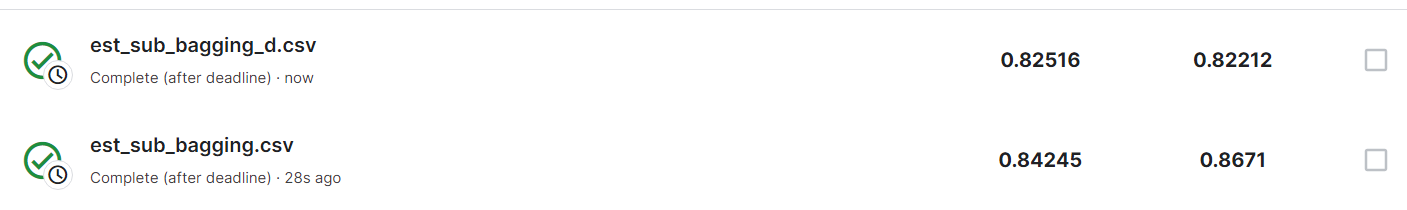

diect prediction
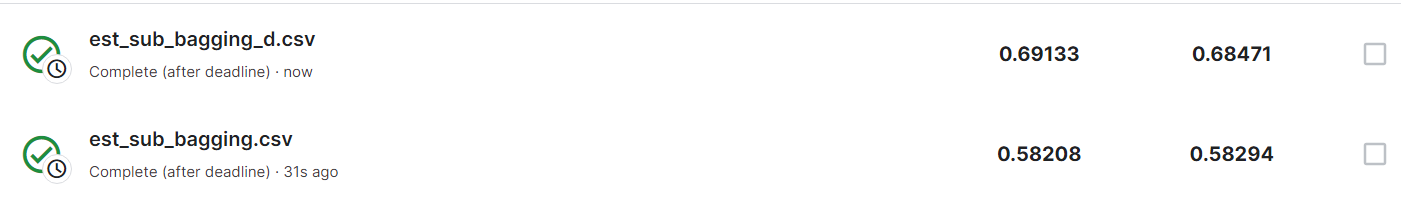